In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
import sentencepiece as sp
from tqdm import tqdm
import math
import numpy as np

In [2]:
!pip install rouge_score sacrebleu

In [3]:
from sacrebleu.metrics import BLEU, CHRF
from rouge_score import rouge_scorer

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)

Using device: cpu


In [5]:
tokenizer = sp.SentencePieceProcessor()
tokenizer.Load('D:/Workspace/PYTHON/NLP/Project2/tokenizer/unigram/unigram_tokenizer.model')
    

True

In [6]:
VOCAB_SIZE = tokenizer.get_piece_size()
PAD_ID = tokenizer.piece_to_id('<pad>')
    
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"PAD ID: {PAD_ID}")
    

Vocabulary size: 256
PAD ID: 0


In [7]:
data = torch.load('D:/Workspace/PYTHON/NLP/Project2/Data/span_corruption_dataset.pt')
input_ids = data['input_ids']
target_ids = data['target_ids']
    

In [8]:
split_idx = int(len(input_ids) * 0.8)
train_input = input_ids[:split_idx]
train_target = target_ids[:split_idx]
val_input = input_ids[split_idx:]
val_target = target_ids[split_idx:]

print(f"Training samples: {len(train_input)}")
print(f"Validation samples: {len(val_input)}")


Training samples: 8197
Validation samples: 2050


In [9]:
class UrduDataset(Dataset):
    def __init__(self,input_ids,target_ids):
        super().__init__()
        self.input_ids = input_ids
        self.target_ids = target_ids

    def __len__(self):
        return len(self.input_ids)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'target_ids': torch.tensor(self.target_ids[idx], dtype=torch.long)
        }
    
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    target_ids = [item['target_ids'] for item in batch]
    
    input_ids=nn.utils.rnn.pad_sequence(input_ids,batch_first=True,padding_value=PAD_ID)
    target_ids=nn.utils.rnn.pad_sequence(target_ids,batch_first=True,padding_value=PAD_ID)
    return {
        'input_ids': input_ids,
        'target_ids': target_ids
    }

In [10]:
train_dataset = UrduDataset(train_input, train_target)
val_dataset = UrduDataset(val_input, val_target)
    
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=32, 
    shuffle=False,
    collate_fn=collate_fn
)


# --------------------TRANSFORMER CODE--------------------------

In [11]:


def get_positional_encoding(max_seq_len, dm):
    pos=torch.arange(max_seq_len).unsqueeze(1)               
    denom = 10000 ** (2 * torch.arange(0, dm//2)/ dm)
    angles = pos / denom
    PE = torch.zeros(max_seq_len, dm)
    PE[:, 0::2] = torch.sin(angles)         
    PE[:, 1::2] = torch.cos(angles)  
    return PE    

torch.Size([20, 50])
tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  6.3795e-01,  7.7008e-01,  4.6056e-01,
          8.8763e-01,  3.2511e-01,  9.4568e-01,  2.2709e-01,  9.7387e-01,
          1.5783e-01,  9.8747e-01,  1.0943e-01,  9.9399e-01,  7.5785e-02,
          9.9712

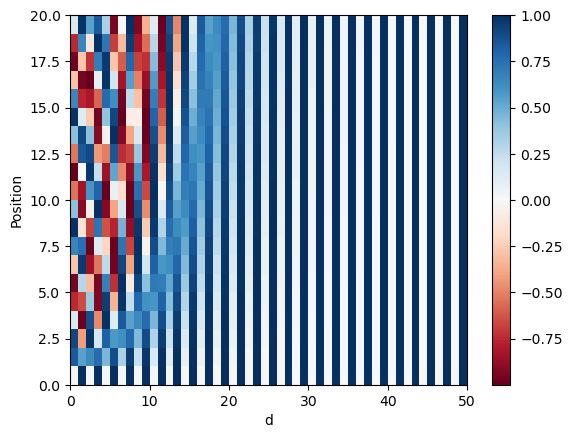

In [12]:
T_pos_encoding = get_positional_encoding(20, 50)
print(T_pos_encoding.shape)
print(T_pos_encoding)

plt.pcolormesh(T_pos_encoding, cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 50))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [13]:

def create_padding_mask(seq):
    """Create padding mask: True for padding positions"""
    return seq == PAD_ID
def create_look_ahead_mask(size):
    """Create look_ahead mask for decoder"""
    mask = torch.triu(torch.ones(size, size,), diagonal=1)
    return mask.bool()
l=create_look_ahead_mask(4)
print(l.shape)
print(l)

torch.Size([4, 4])
tensor([[False,  True,  True,  True],
        [False, False,  True,  True],
        [False, False, False,  True],
        [False, False, False, False]])


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super()._init_()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def split_heads(self, x):
        batch_size, seq_len, d_model = x.size()
        x = x.view(batch_size, seq_len, self.num_heads, self.d_k)
        return x.transpose(1, 2)
    
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        output = torch.matmul(attention_weights, V)
        return output, attention_weights
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        Q = self.split_heads(self.W_q(query))
        K = self.split_heads(self.W_k(key))
        V = self.split_heads(self.W_v(value))
        attn_output, _ = self.scaled_dot_product_attention(Q, K, V, mask)
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.view(batch_size, -1, self.d_model)
        output = self.W_o(attn_output)
        return output


In [14]:

def FullyConnected(embedding_dim,fully_connected_dim,dropout=0.1):
    return nn.Sequential(
        nn.Linear(embedding_dim,fully_connected_dim),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(fully_connected_dim,embedding_dim)
    )

<center><img src="img/encoder_layer.png" alt="Encoder" width="400"/></center>

<center><caption><b>Transformer encoder layer</caption></center>


In [15]:
class EncoderLayer(nn.Module):
    def __init__(self,embedding_dim,num_heads,ffn_dim,dropout_rate=0.1,layernorm_eps=1e-6):
        super().__init__()
        self.mha=nn.MultiheadAttention(embed_dim=embedding_dim,num_heads=num_heads,dropout=dropout_rate,batch_first=True)
        self.ffn=FullyConnected(embedding_dim,ffn_dim)
        self.layernorm1=nn.LayerNorm(embedding_dim,eps=layernorm_eps)
        self.layernorm2=nn.LayerNorm(embedding_dim,eps=layernorm_eps)
        self.dropout_attn = nn.Dropout(dropout_rate)
        self.dropout_ffn=nn.Dropout(dropout_rate)

    def forward(self,x, mask):
        """
        Forward pass for the Encoder Layer    
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            encoder_layer_out -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        attn_output,_=self.mha(query=x,value=x,key=x,key_padding_mask=mask)# (batch_size, input_seq_len, embedding_dim)
        attn_output = self.dropout_attn(attn_output)
        skip_x_attn=self.layernorm1(x+attn_output)

        ffn_output=self.ffn(skip_x_attn)
        ffn_output=self.dropout_ffn(ffn_output)

        out=self.layernorm2(ffn_output+skip_x_attn)
        return out

<center><img src="img/encoder.png" alt="Encoder" width="400"/></center>

<center><caption><b>Full encoder</caption></center>


In [16]:
class Encoder(nn.Module):
    def __init__(self,num_layers, embedding_dim, num_heads, ffn_dim, input_vocab_size,max_seq_len, dropout_rate=0.1, padding_id=0):
        super().__init__()
        self.embedding_dim=embedding_dim
        self.num_layers=num_layers
        self.embedding= nn.Embedding(input_vocab_size,embedding_dim,padding_idx=padding_id)
        self.pos_encoding= get_positional_encoding(max_seq_len,embedding_dim)
        
        self.enc_layers=nn.ModuleList([
            EncoderLayer(embedding_dim,num_heads,ffn_dim,dropout_rate) for _ in range(num_layers) 
        ])
        self.dropout= nn.Dropout(dropout_rate)
        self.scale_dm = torch.sqrt(torch.tensor(self.embedding_dim))
    def forward(self,x,padding_mask):
         """
        Arguments:
            x: Tensor of shape (batch_size, input_seq_len)
            mask: key padding mask of shape (batch_size, input_seq_len)
        Returns:
            output: Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
         seq_len=x.shape[1]
         x=self.embedding(x)*self.scale_dm
         pos_enc=self.pos_encoding[:seq_len,:].to(x.device)
         x=self.dropout(x+pos_enc)

         for i in range(self.num_layers):
             x=self.enc_layers[i](x,padding_mask)
        
         return x

<center><img src="img/decoder_layer.png"  width="300"/></center>

<center><caption><b>Transformer decoder layer</caption></center>


In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self,embedding_dim,num_heads,ffn_dim,dropout_rate=0.1,layernorm_eps=1e-6):
        super().__init__()
        self.mha1=nn.MultiheadAttention(embedding_dim,num_heads,dropout=dropout_rate,batch_first=True)
        self.mha2=nn.MultiheadAttention(embedding_dim,num_heads,dropout=dropout_rate,batch_first=True)
        self.ffn=FullyConnected(embedding_dim,ffn_dim)
        
        self.layernorm1=nn.LayerNorm(embedding_dim,eps=layernorm_eps)
        self.layernorm2=nn.LayerNorm(embedding_dim,eps=layernorm_eps)
        self.layernorm3=nn.LayerNorm(embedding_dim,eps=layernorm_eps)

        self.dropout1=nn.Dropout(dropout_rate)
        self.dropout2=nn.Dropout(dropout_rate)
        self.dropout3=nn.Dropout(dropout_rate)
    def forward(self,x,enc_out,look_ahead_mask,padding_mask):
        
        masked_att,_=self.mha1(query=x,key=x,value=x,attn_mask=look_ahead_mask)
        out1 = self.layernorm1( x + self.dropout1(masked_att))

        cross_att,_=self.mha2(query=out1,key=enc_out,value=enc_out,key_padding_mask=padding_mask)
        out2=self.layernorm2(out1+self.dropout2(cross_att))

        ffn_out=self.ffn(out2)
        out3=self.layernorm3(out2+self.dropout3(ffn_out))

        return out3
        

<center><img src="img/decoder.png"  width="300"/></center>

<center><caption><b>Full decoder</caption></center>


In [18]:
class Decoder(nn.Module):
    def __init__(self,num_layers,embedding_dim,num_heads,ffn_dim,target_vocab_size,max_seq_len,dropout_rate=0.1, padding_id=0):
        super().__init__()
        self.num_layers=num_layers
        self.embedding_dim=embedding_dim
        self.embedding=nn.Embedding(target_vocab_size,embedding_dim,padding_idx=padding_id)
        self.pos_encoding=get_positional_encoding(max_seq_len,embedding_dim)
        self.dec_layers=nn.ModuleList([
            DecoderLayer(embedding_dim,num_heads,ffn_dim,dropout_rate) for _ in range(num_layers)
        ])
        self.dropout=nn.Dropout(dropout_rate)
        self.scale_dm = torch.sqrt(torch.tensor(self.embedding_dim))
    def forward(self,x, enc_output,look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            look_ahead_mask -- Boolean mask for the target_input (batch_size, tgt_seq_len, tgt_seq_len)
            padding_mask -- Boolean mask for the second multihead attention layer (batch_size, src_seq_len)
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
        """
        seq_len=x.shape[1]
        x=self.embedding(x)* self.scale_dm
        pos_enc=self.pos_encoding[:seq_len,:].to(x.device)
        x=self.dropout(x+pos_enc)
        for i in range(self.num_layers):
            x= self.dec_layers[i](x,enc_output,look_ahead_mask,padding_mask)

        return x

<center><img src="img/transformer.png"  width="400"/></center>

<center><caption><b>Full decoder</caption></center>


In [19]:
class Transformer(nn.Module):
    def __init__(self,vocab_size=256,max_seq_len=100,padding_idx=0):
        super().__init__()
        self.encoder=Encoder(num_layers=2,embedding_dim=256,num_heads=4,ffn_dim=1024,input_vocab_size=vocab_size,max_seq_len=max_seq_len,padding_id=padding_idx)
        self.decoder=Decoder(num_layers=2,embedding_dim=256,num_heads=4,ffn_dim=1024,target_vocab_size=vocab_size,max_seq_len=max_seq_len,padding_id=padding_idx)
        self.final_layer=nn.Linear(in_features=256,out_features=vocab_size)

    def forward(self,src,tgt,padding_mask,tgt_look_ahead_mask,teacher_forcing=0):

        batch_len,tgt_len = tgt.shape
        dec_input= tgt[:,0:1]

        enc_output =self.encoder(src,padding_mask)    

        outputs=[]
        for i in range(0,tgt_len):
            
            tgt_look_ahead_mask =create_look_ahead_mask(dec_input.size(1))
            dec_out=self.decoder(dec_input,enc_output,tgt_look_ahead_mask,padding_mask)
            pred=self.final_layer(dec_out)

            outputs.append(pred[:,-1:,:])

            if i<tgt_len-1:

                tf=torch.rand(batch_len,1)<teacher_forcing
                pred_t= pred[:,-1:,:].argmax(dim=-1)
                ground_t=tgt[:,i+1:i+2]
                next_t=torch.where(tf,ground_t,pred_t)

                dec_input= torch.cat([dec_input,next_t],dim=1)

        output=torch.cat(outputs,dim=1)
        return output

        

# --------------------TRAINING-TEST CODE--------------------------

In [20]:
def train_epoch(model,dataloader,criterian,optimizer,teacher_forcing=1.0):
    model.train()
    total_loss=0

    progress_bar=tqdm(dataloader,desc=f"Training (TF={teacher_forcing})")

    for batch in progress_bar:
        input_ids = batch['input_ids']
        target_ids = batch['target_ids']

        decoder_input = target_ids[:, :-1]
        decoder_target = target_ids[:, 1:]
                
        padding_mask=create_padding_mask(input_ids)
        tgt_look_ahead_mask=create_look_ahead_mask(decoder_input.size(1))

        optimizer.zero_grad()
        output= model(input_ids,decoder_input,padding_mask,tgt_look_ahead_mask,teacher_forcing=teacher_forcing)


        loss = criterian(output.reshape(-1,output.size(-1)),decoder_target.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix({'Train loss': loss.item()})

    return total_loss / len(dataloader)
        
        

In [21]:
def calculate_bleu(predictions, references):
    """Calculate BLEU score"""
    bleu = BLEU()
    score = bleu.corpus_score(predictions, [references])
    return score.score

def calculate_rouge_l(predictions, references):
    """Calculate ROUGE-L score"""
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)
    scores = []
    for pred, ref in zip(predictions, references):
        score = scorer.score(ref, pred)
        scores.append(score['rougeL'].fmeasure)
    return np.mean(scores) * 100

def calculate_chrf(predictions, references):
    """Calculate chrF score"""
    chrf = CHRF()
    score = chrf.corpus_score(predictions, [references])
    return score.score

def calculate_perplexity(loss):
    """Calculate perplexity from loss"""
    return math.exp(min(loss, 100))

In [27]:
def evaluate(model, dataloader, criterian):
    model.eval()
    total_loss = 0
    predictions = []
    references = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating (no teacher forcing)")
        for batch in progress_bar:
            input_ids = batch['input_ids']
            target_ids = batch['target_ids']

            decoder_input = target_ids[:, :-1]
            decoder_target = target_ids[:, 1:]

            padding_mask = create_padding_mask(input_ids)
            tgt_look_ahead_mask = create_look_ahead_mask(decoder_input.size(1))

            output = model(input_ids, decoder_input, padding_mask, tgt_look_ahead_mask, teacher_forcing=0)
            loss = criterian(output.reshape(-1, output.size(-1)), decoder_target.reshape(-1))

            total_loss += loss.item()
            progress_bar.set_postfix({'val loss': loss.item()})

            # Decode predictions and references for metrics
            pred_ids = output.argmax(dim=-1).cpu().tolist()
            tgt_ids = decoder_target.cpu().tolist()
            for pred, ref in zip(pred_ids, tgt_ids):
                pred_text = tokenizer.decode(pred)
                ref_text = tokenizer.decode(ref)
                predictions.append(pred_text)
                references.append(ref_text)

    avg_loss = total_loss / len(dataloader)

    bleu_score = calculate_bleu(predictions, references)
    rouge_score = calculate_rouge_l(predictions, references)
    chrf_score = calculate_chrf(predictions, references)
    perplexity = calculate_perplexity(avg_loss)

    print("\nEvaluation Results:")
    print("  Val Loss: ",avg_loss)
    print("  BLEU: ",bleu_score)
    print("  ROUGE-L: ",rouge_score)
    print("  chrF: ",chrf_score)
    print("  Perplexity: ",perplexity)


    return {
        'predictions': predictions[:10],
        'references': references[:10]
    }

In [24]:
model=Transformer(vocab_size=VOCAB_SIZE,padding_idx=PAD_ID)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    

Model parameters: 3,883,264


In [25]:
criterian=nn.CrossEntropyLoss(ignore_index=PAD_ID)
optimizer =torch.optim.Adam(model.parameters(),lr=1e-3)
scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=3,factor=0.5) 

In [26]:
loss =train_epoch(model,train_loader,criterian,optimizer,teacher_forcing=0.6)

Training (TF=0.6):   2%|▏         | 6/257 [00:11<07:46,  1.86s/it, Train loss=3.83]


KeyboardInterrupt: 

In [28]:
output = evaluate(model, val_loader,criterian)
        

Evaluating (no teacher forcing): 100%|██████████| 65/65 [00:35<00:00,  1.85it/s, val loss=3.39]



Evaluation Results:
  Val Loss:  3.6324480790358322
  BLEU:  0.0
  ROUGE-L:  83.48919860627177
  chrF:  30.289035775341734
  Perplexity:  37.805253673368846


In [29]:
print("Examples:")
for i in range(10):
    print(f"\n  Example {i+1}:")
    print(f"    Prediction: {output['predictions'][i]}")
    print(f"    Reference:  {output['references'][i]}")

Examples:

  Example 1:
    Prediction: <mask>
    Reference:  <mask>ر<mask>یا<mask>ر<mask>ان

  Example 2:
    Prediction: <mask>
    Reference:  <mask>ر

  Example 3:
    Prediction: <mask>
    Reference:  <mask> حکومت

  Example 4:
    Prediction: <mask>
    Reference:  <mask> این ڈی ای

  Example 5:
    Prediction: <mask>
    Reference:  <mask> رہ

  Example 6:
    Prediction: <mask>
    Reference:  <mask>ر<mask>س<mask>تی

  Example 7:
    Prediction: <mask>
    Reference:  <mask>ٹ<mask> وو<mask> کی م

  Example 8:
    Prediction: <mask>
    Reference:  <mask>ابوں

  Example 9:
    Prediction: <mask>
    Reference:  <mask>انی کے ساتھ ایک<mask>و

  Example 10:
    Prediction: <mask>
    Reference:  <mask> کی
